---
title: "UNICEF Assignment"
subtitle: "How refugee influx shapes economic health in host countries"
author:
  - name: Muskan Singh
    email: muskan.singh2@mail.dcu.ie
format:
  html:
    toc: true
    theme: cosmo
    embed-resources: true
    code-fold: true
    code-tools: true
    toc-title: Report Contents
    date: 2025-04-27
    mainfont: Source Sans Pro
    highlight-style: github
execute:
  warning: false
  message: false
---
**Connect with me on [LinkedIn](https://www.linkedin.com/in/muskan-singh-013457191/).**

## Introduction to UNICEF
![](https://youthnetworks.net/wp-content/uploads/2020/10/4f204176-9d5e-43b7-8605-af8566d519e2.png)

The United Nations International Children's Emergency Fund (UNICEF) is a leading humanitarian organization dedicated to protecting and promoting the rights and well-being of every child. Founded in 1946, UNICEF operates in over 190 countries and territories, providing emergency relief, healthcare, nutrition, education, and protection services to vulnerable children and families.
With a mission rooted in the United Nations Convention on the Rights of the Child, UNICEF works tirelessly to ensure that every child survives, thrives, and reaches their full potential, regardless of circumstance.


---

### Why Refugee Influx is an Important Indicator
- The influx of refugees into a host country is a critical indicator of both humanitarian needs and economic impact.
- Refugees often flee violence, persecution, and disasters, seeking safety and stability.
- Refugee arrivals significantly influence the host nation's economy by impacting:
  - Housing
  - Education
  - Healthcare
  - Labor markets
  - Public infrastructure
- Monitoring refugee influx helps:
  - Policymakers, international organizations, and communities plan appropriate responses.
  - Ensure the protection of human rights.
  - Promote sustainable economic development.
- In the context of UNICEF's work:
  - Addressing the needs of refugee children and families is essential.
  - Helps in protecting lives, fostering social inclusion, and building resilient communities.



## Key Findings

- **Disproportionate Burden on Lower-Income Countries:**  
  The analysis indicates that lower-income countries often host a significant number of refugees relative to their economic capacity. This is evident from the high "refugees per GNI per capita" ratios observed in several nations, suggesting that these countries bear a considerable economic burden in supporting refugee populations.

- **GDP Growth and Refugee Influx:**  
  Contrary to common perceptions, the data does not show a consistent negative correlation between refugee influx and GDP growth. In some instances, countries with substantial refugee populations have maintained or even experienced positive GDP growth rates, indicating potential economic resilience and adaptability.

- **Inflation Trends:**  
  Examination of inflation rates over time in major refugee-hosting countries reveals that inflation is more closely tied to global economic trends rather than refugee influx. This suggests that concerns about refugees causing significant inflationary pressures may be overstated.


In [61]:
#| echo: false
#| output: false
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries

In [62]:
#| output: false
import polars as pl
from plotnine import *
import polars.selectors as cs
import geopandas as gp

# Set Polars to display more rows/columns
pl.Config.set_tbl_rows(10000)  # Number of rows to display
pl.Config.set_tbl_cols(100)    # Number of columns to display

polars.config.Config

## Dataset Preparation and Cleaning Process

To build a robust and coherent foundation for studying refugee influx and its economic effects on host countries, two primary datasets were prepared: the refugee indicator dataset and the host country economic metadata. Redundant columns containing constant values were systematically identified and removed, and irrelevant metadata such as ISO codes was dropped. Consistent variable naming was applied to align both datasets, enabling a smooth inner join on `country`, `year`, and `iso3`. Missing values, particularly in Kyrgyzstan’s population data, were addressed using interpolation to maintain data continuity without introducing external biases. A new feature, `total_refugees`, was engineered by estimating the absolute number of refugees based on the refugees per GNI per capita metric, enhancing the depth and interpretability of the analysis.

To further enrich the dataset, geographic metadata linking each country to its continent and sub-region was merged from external ISO standards, enabling regional breakdowns in the analysis. Additionally, world shapefile geometry data was imported to support the creation of spatial visualizations such as choropleth maps. Following these steps—cleaning, interpolation, feature engineering, and geographic enhancement—the final dataset provides a high-integrity, multi-dimensional view, well-equipped to support detailed, regionally focused, and statistically rigorous exploration of refugee dynamics and their economic implications.


In [63]:
# Load refugee indicator and host country metadata datasets
refugee_indicators = pl.read_csv("/content/drive/MyDrive/Assignment/unicef_indicator.csv")
host_countries_metadata = pl.read_csv(
    "/content/drive/MyDrive/Assignment/unicef_metadata.csv",
    schema_overrides={"Population, total": pl.Int64},
    ignore_errors=True
)

# Identify redundant columns (those with only a single unique value)
def get_redundant_columns(df):
    return {col: df[col].unique()[0] for col in df.columns if len(df[col].unique()) == 1}

# Detect redundant columns in both datasets
redundant_indicator_cols = get_redundant_columns(refugee_indicators)
redundant_metadata_cols = get_redundant_columns(host_countries_metadata)

# Define irrelevant columns to be removed
irrelevant_indicator_cols = list(redundant_indicator_cols.keys()) + ["alpha_2_code", "numeric_code"]
irrelevant_metadata_cols = list(redundant_metadata_cols.keys()) + ["alpha_2_code", "numeric_code"]

# Drop irrelevant and redundant columns
refugee_indicators = refugee_indicators.drop(irrelevant_indicator_cols)
host_countries_metadata = host_countries_metadata.drop(irrelevant_metadata_cols)

# Rename columns for consistency and easier merging with geographic datasets
refugee_indicators = refugee_indicators.rename({
    "time_period": "year",
    "obs_value": "refugees_per_gni_pc",
    "alpha_3_code": "iso3",
})

host_countries_metadata = host_countries_metadata.rename({
    "Population, total": "population",
    "GDP per capita (constant 2015 US$)": "gdp_per_capita",
    "GNI (current US$)": "gni",
    "Inflation, consumer prices (annual %)": "inflation",
    "Life expectancy at birth, total (years)": "life_expectancy",
    "Military expenditure (% of GDP)": "military_expenditure",
    "Fossil fuel energy consumption (% of total)": "fossil_fuel_consumption",
    "GDP growth (annual %)": "gdp_growth",
    "Birth rate, crude (per 1,000 people)": "birth_rate",
    "Hospital beds (per 1,000 people)": "hospital_beds",
    "alpha_3_code": "iso3",
})

# Define readable descriptions for each column
column_description = {
    "population": "Population, total",
    "gdp_per_capita": "GDP per capita (constant 2015 US$)",
    "gni": "GNI (current US$)",
    "inflation": "Inflation, consumer prices (annual %)",
    "life_expectancy": "Life expectancy at birth, total (years)",
    "military_expenditure": "Military expenditure (% of GDP)",
    "fossil_fuel_consumption": "Fossil fuel energy consumption (% of total)",
    "gdp_growth": "GDP growth (annual %)",
    "birth_rate": "Birth rate, crude (per 1,000 people)",
    "hospital_beds": "Hospital beds (per 1,000 people)",
    "refugees_per_gni_pc": "Refugees per GNI per capita (per $1)",
    "total_refugees": "Total refugees"
}

# Merge the two datasets on country, year, and ISO3 code
full_data = refugee_indicators.join(host_countries_metadata, on=["country", "year", "iso3"], how="inner")

# Function to calculate the percentage of null values per year and column
def column_wise_null_percentage(df: pl.DataFrame, col) -> pl.DataFrame:
    total_rows_per_year = df.group_by(col).agg(pl.len().alias("total_rows"))

    nulls_per_year_var = df.unpivot(cs.all(), index=[col]).group_by([col, "variable"]).agg(pl.col("value").null_count().alias("null_count"))

    # Merge with total rows per year
    nulls_per_year_var = nulls_per_year_var.join(total_rows_per_year, on=col)

    # Calculate null percentages
    nulls_per_year_var = nulls_per_year_var.with_columns(
        (pl.col("null_count") / pl.col("total_rows") * 100).alias("null_percentage")
    )

    return nulls_per_year_var.sort([col, "variable"])

# Check for missing values by country
nulls_countrywise = column_wise_null_percentage(full_data, "country")

# Fill missing population values for Kyrgyzstan using interpolation
full_data = (
    full_data.with_columns(
        pl.when(pl.col("country") == "Kyrgyzstan")
        .then(
            pl.col("population").interpolate()
        )
        .otherwise(pl.col("population"))
        .alias("population")
    )
)

# Engineer a new feature: estimated total number of refugees
full_data = full_data.with_columns(
    (pl.col("refugees_per_gni_pc") * (pl.col("gni") / pl.col("population"))).cast(pl.Int64).alias("total_refugees")
)

# Load geographic metadata (continent and sub-region) from an external source
country_geo_metadata = (
    pl.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/refs/heads/master/all/all.csv")
    .rename({"alpha-3": "iso3", "region": "continent"})
    .select(["iso3", "continent", "sub-region"])
)

# Merge geographic metadata with the full dataset
full_data = full_data.join(country_geo_metadata, ["iso3"], "inner")

# Import world geometry shapefile data for map visualizations
shape_world = gp.read_file("https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/world-administrative-boundaries/exports/shp")

# Set global configuration for plots
g_theme = theme_bw()
latest_year = full_data["year"].max()
plot_title_theme = element_text(ha="left", size=10, weight="bold", margin={"b": 10})

## Understanding Refugee Settlement Patterns Across the Globe
This world map illustrates the global distribution of refugees, providing a geographic snapshot of where displaced populations have resettled as of the latest data. Clear clusters emerge: neighboring countries to major conflict zones in the Middle East, Central Africa, and South Asia host disproportionately large refugee populations compared to countries further afield.

Regional patterns are evident — countries like **Iran** and **Turkey** serve as major hubs, while wealthier nations in Europe and North America also host significant but comparatively smaller shares relative to their population size and GDP. The color intensity corresponds to the total refugee count.



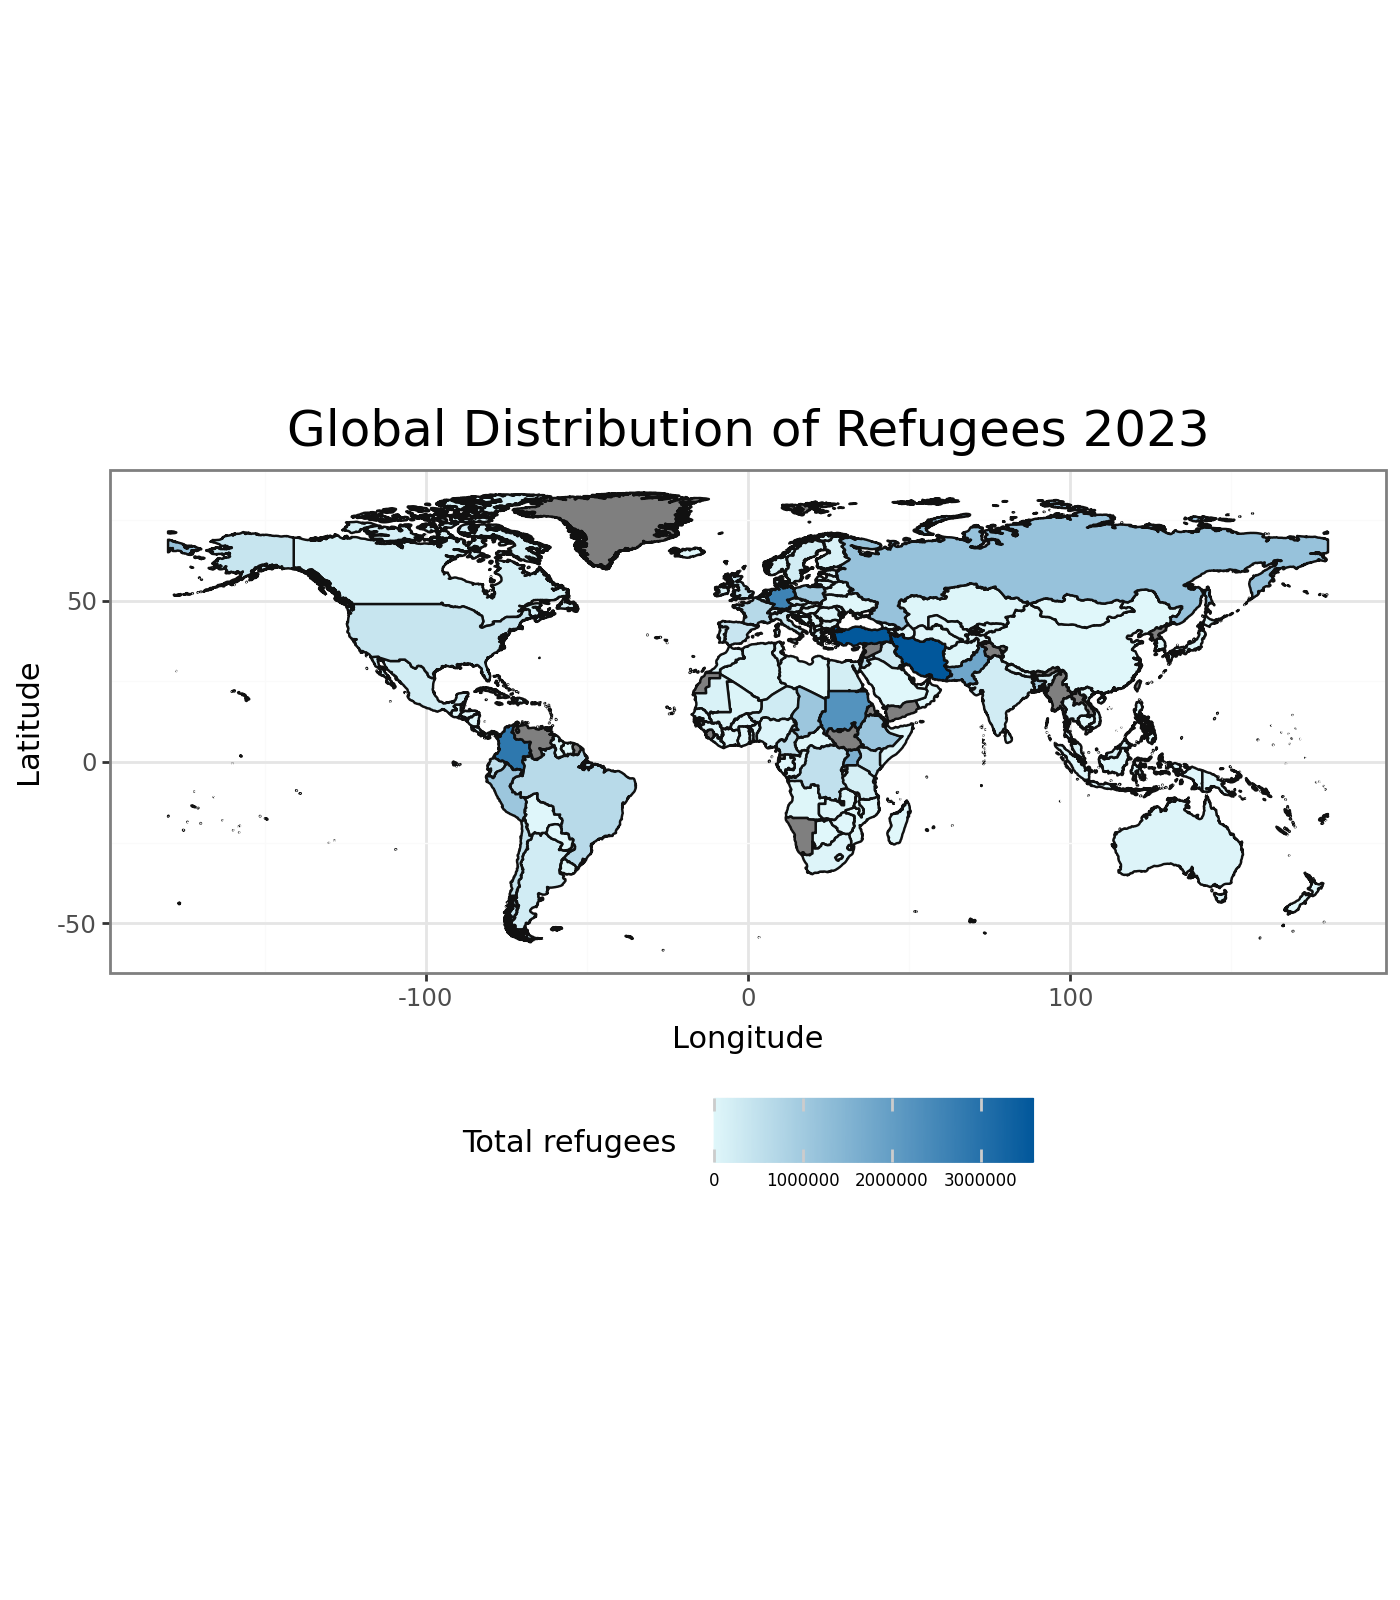

In [64]:
(
  shape_world.merge(full_data.filter(pl.col("year") == latest_year).to_pandas(), on="iso3", how="outer")
  >>
  ggplot(aes(fill="total_refugees"))
    + geom_map()
    + coord_fixed()
    + labs(
        title="Global Distribution of Refugees 2023",
        x="Longitude",
        y="Latitude",
      )
    + scale_fill_gradient(
        name=column_description["total_refugees"],
        low="#e0f7fa",
        high="#01579b"
      )
    + g_theme
    + theme(
        plot_title=element_text(size=18),
        figure_size=(7, 8),
        legend_position="bottom",
        legend_direction="horizontal",
        legend_text=element_text(size=6)
      )
)


## Leading Hosts: Nations Bearing the Greatest Refugee Burden
This bar chart presents a clear overview of the top countries hosting the highest number of refugees globally. The visualization highlights a significant disparity among host nations. Countries such as Iran, Turkey, and Colombia are seen accommodating millions of refugees, reflecting either their geographic proximity to conflict zones or their longstanding asylum policies.

The chart emphasizes that refugee hosting is not uniformly distributed across the world, with certain countries shouldering a disproportionate share of the global refugee burden.

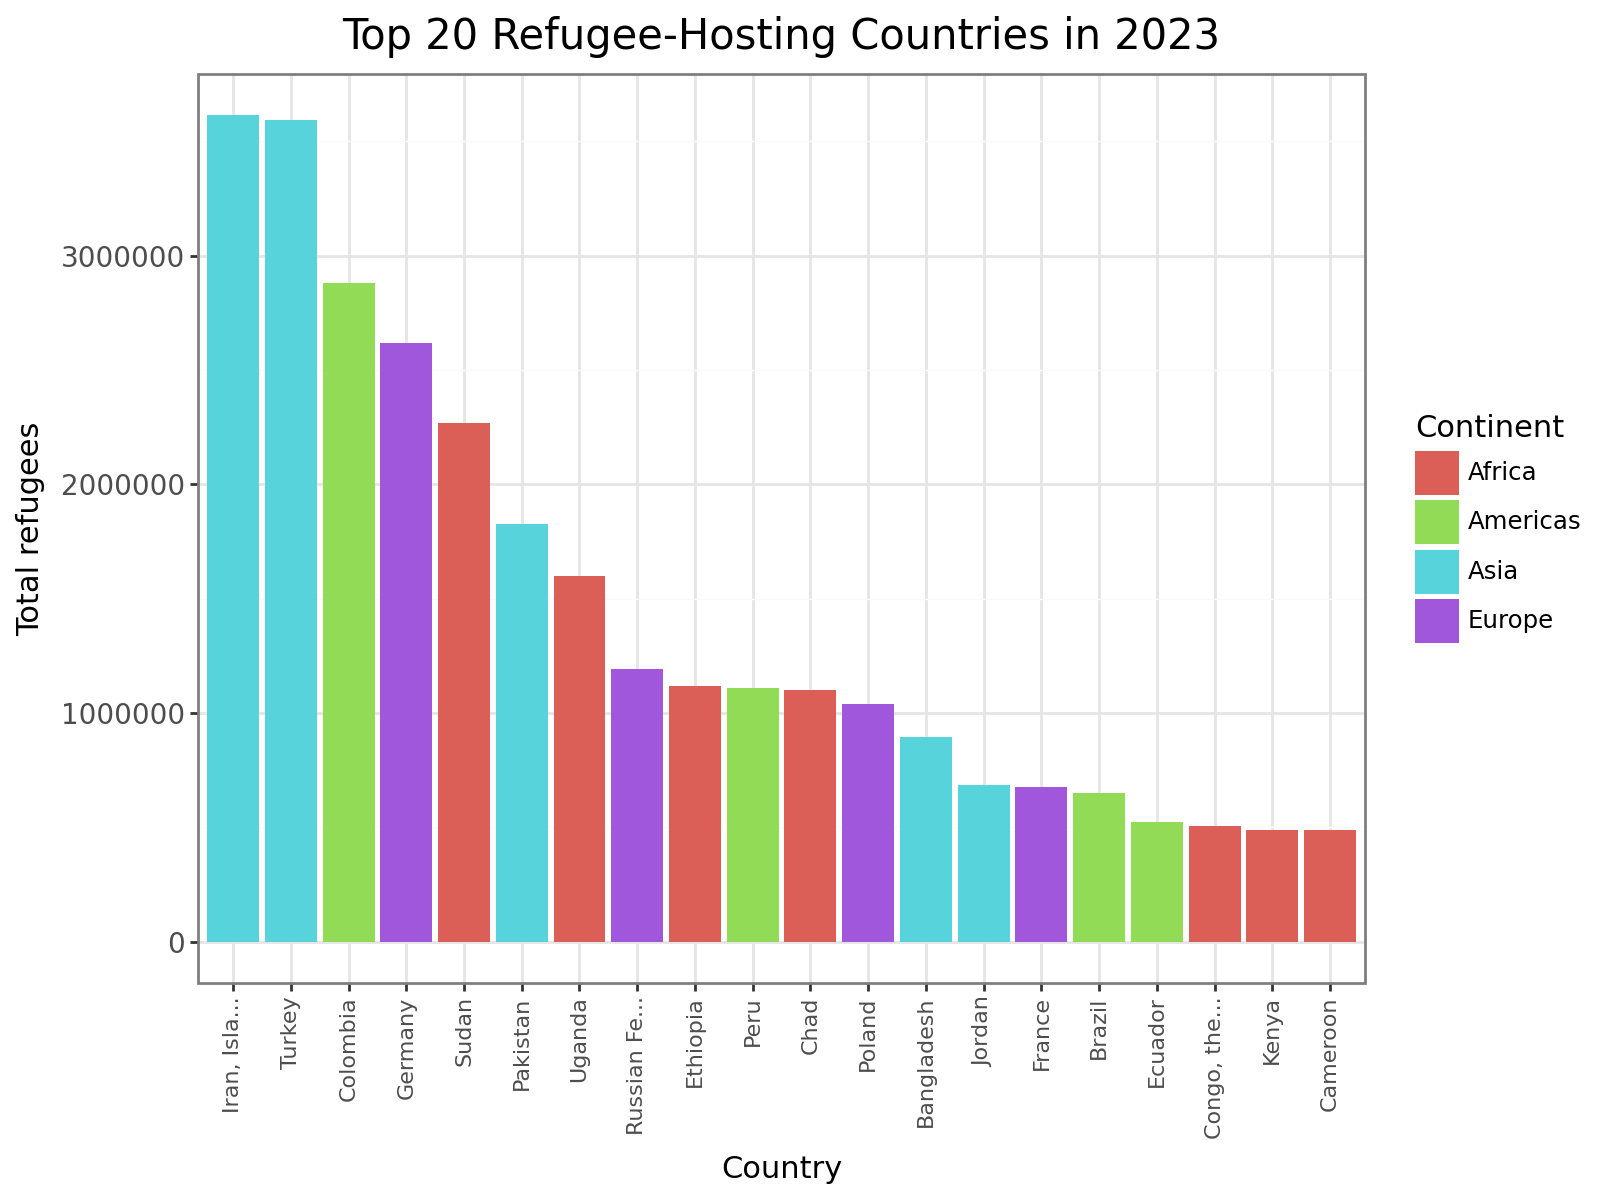

In [65]:
(
  full_data
  .filter(pl.col("year") == latest_year)
  .sort("total_refugees", descending=True)
  .head(20)
  >>
  ggplot(aes("reorder(country, -total_refugees)", "total_refugees", fill="continent"))
  + geom_col()
  + scale_x_discrete(
      labels=lambda l: [label[:10] + "..." if len(label) > 10 else label for label in l],
    )
  + labs(
      title="Top 20 Refugee-Hosting Countries in 2023",
      x="Country",
      y=column_description["total_refugees"],
      fill="Continent"
    )
  + g_theme
  + theme(
      axis_text_x=element_text(rotation=90, size=8),
      axis_text_y=element_text(size=10),
       plot_title=element_text(size=15),
      figure_size=(8,6)
  )
)

## Tracing the Shifting Trends of Refugee Populations Over Two Decades
This scatter plot, enriched with a linear regression line for each country, captures the evolution of refugee populations in the 12 leading host countries from 2001 to 2023. A variety of trajectories emerge: while Turkey experiences a sharp surge following the February 2023 earthquakes, which affected both Turkey and Syria and led to widespread destruction, displacement, and humanitarian crises, particularly in areas with high refugee populations. Germany displays a steadier, linear increase over the two decades.

The fitted regression lines assist in identifying broader trends beyond yearly fluctuations, offering insights into whether refugee numbers are accelerating, stabilizing, or declining in specific contexts. Hovering over individual points provides detailed year-by-year data, enriching the historical narrative behind each country's refugee experience.



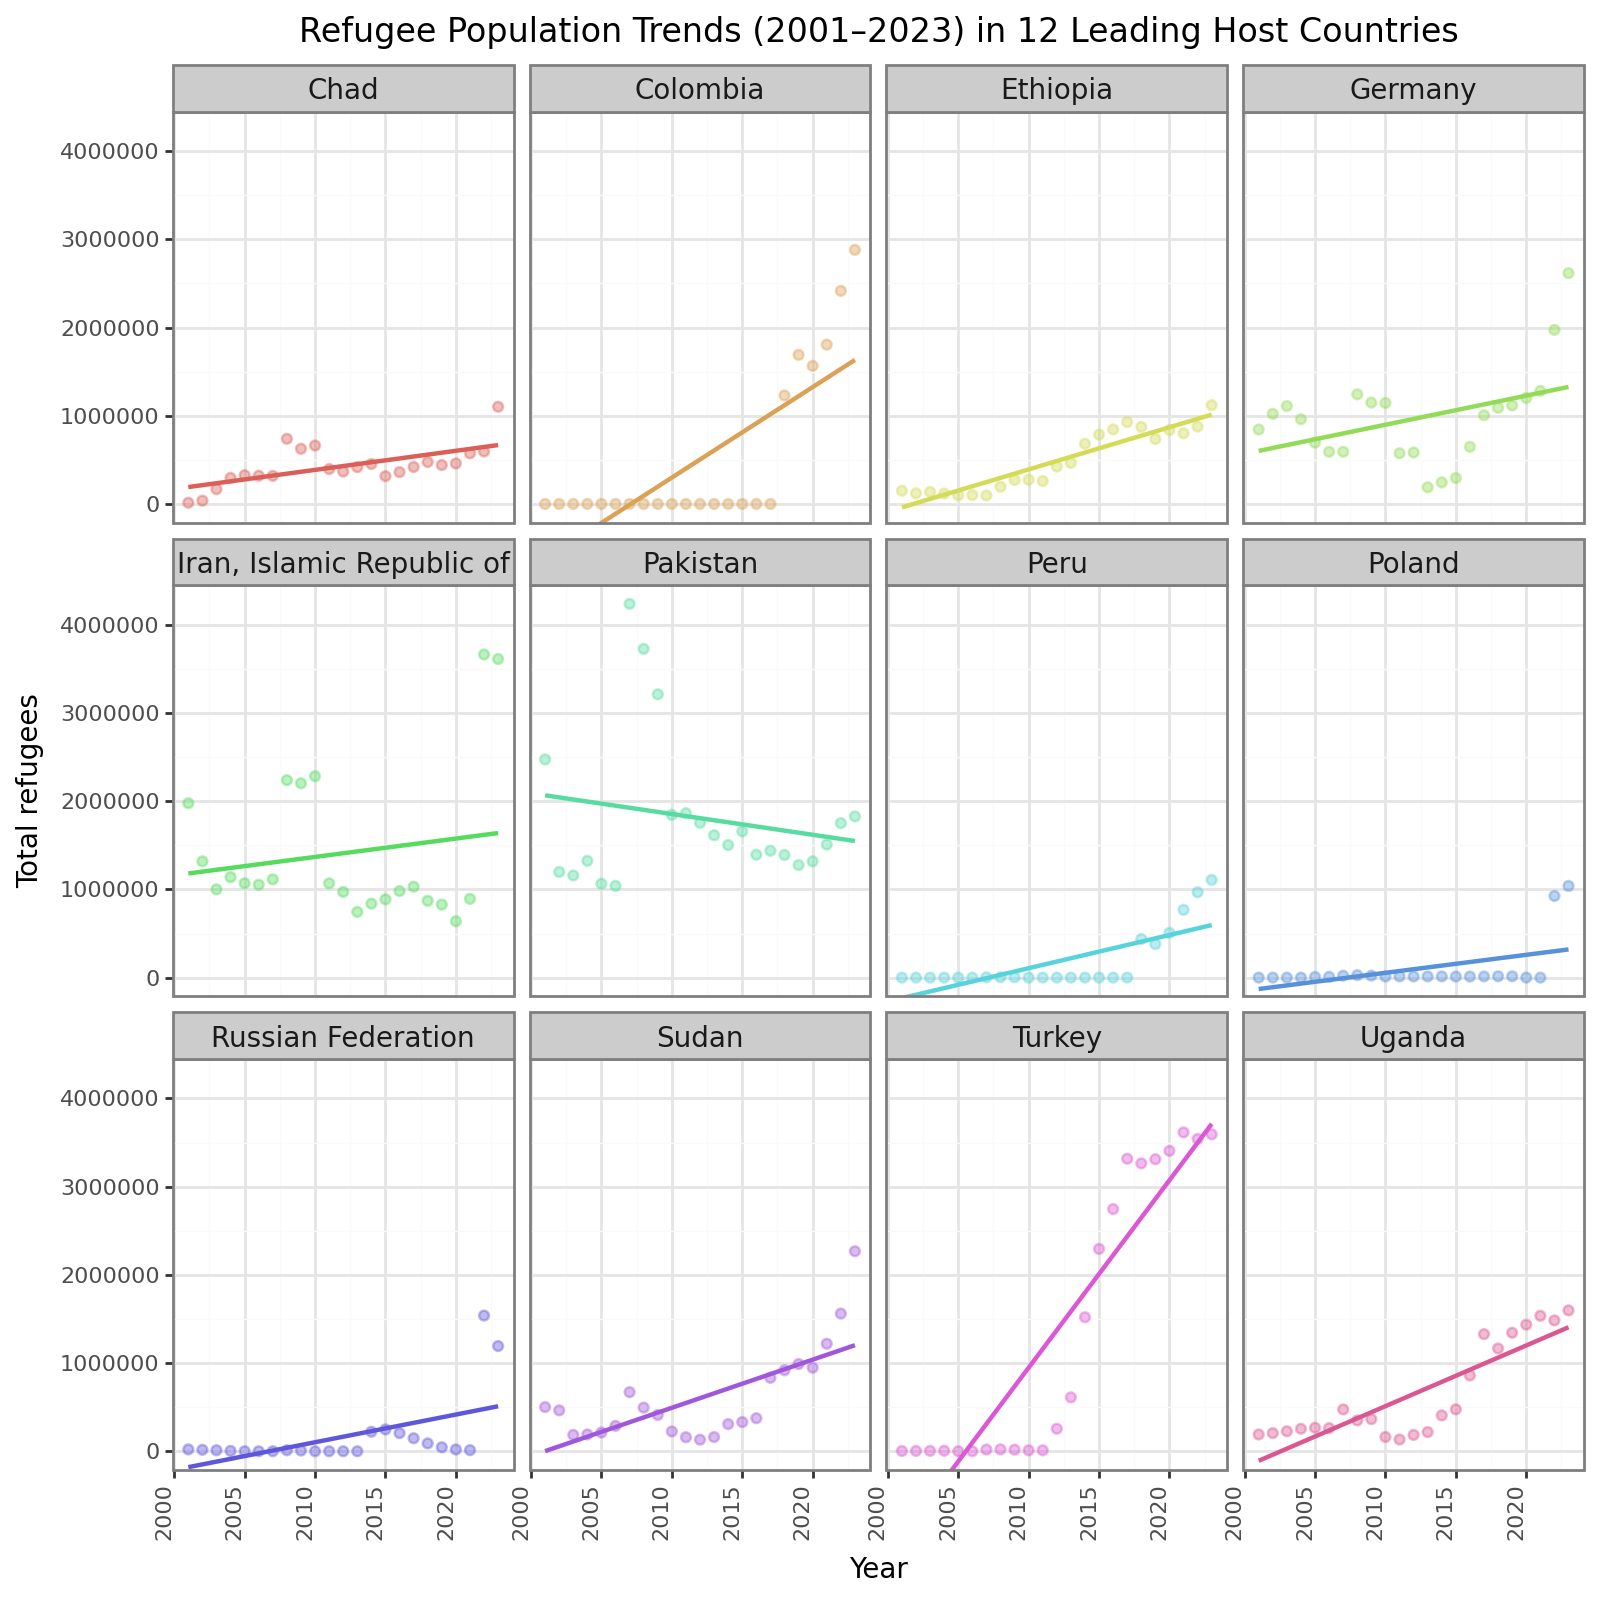

In [66]:
def draw_top_countries_stat(field, facetby, count, title, include_line=False):
  latest_year = full_data["year"].max()
  top_of_latest_year = (
      full_data
      .filter(pl.col("year") == latest_year)
      .sort(field, descending=True)
      .head(count)
    )

  country_list = top_of_latest_year["country"].to_list()

  return(
    full_data
    .filter(pl.col("country").is_in(country_list))
    >>
    ggplot(aes("year", field, color=facetby))
    + geom_point(alpha=0.4)
    + (
        geom_smooth(method="lm", size=0.9, se=False)
        if include_line
        else None
      )
    + labs(
        title=title,
        x="Year",
        y=column_description[field],
      )
    + coord_cartesian(ylim=(0, None))
    + facet_wrap(facetby)
    + g_theme
    + theme(
        legend_position="none",
        axis_text_x=element_text(rotation=90, hjust=1, size=8),
        axis_text_y=element_text(size=8),
        text=element_text(size=10),
        figure_size=(8,8),
        plot_title=element_text(size=12)
      )
  )

draw_top_countries_stat("total_refugees", "country", 12, "Refugee Population Trends (2001–2023) in 12 Leading Host Countries", True)

## Economic Strain of Hosting Refugees Across Global Regions
This faceted scatter plot visualizes the relationship between refugee burden relative to economic strength (measured as refugees per GNI per capita) across different regions. The top 70 countries with the highest burdens are analyzed, revealing that regions such as Sub-Saharan Africa and the Middle East experience far higher economic pressure per refugee hosted than their counterparts in Europe or North America.

By organizing the data regionally, the plot brings out nuanced patterns that would otherwise be hidden in global aggregates. The linear regression lines within each region offer a statistical lens into whether refugee burdens have intensified or lessened over time.

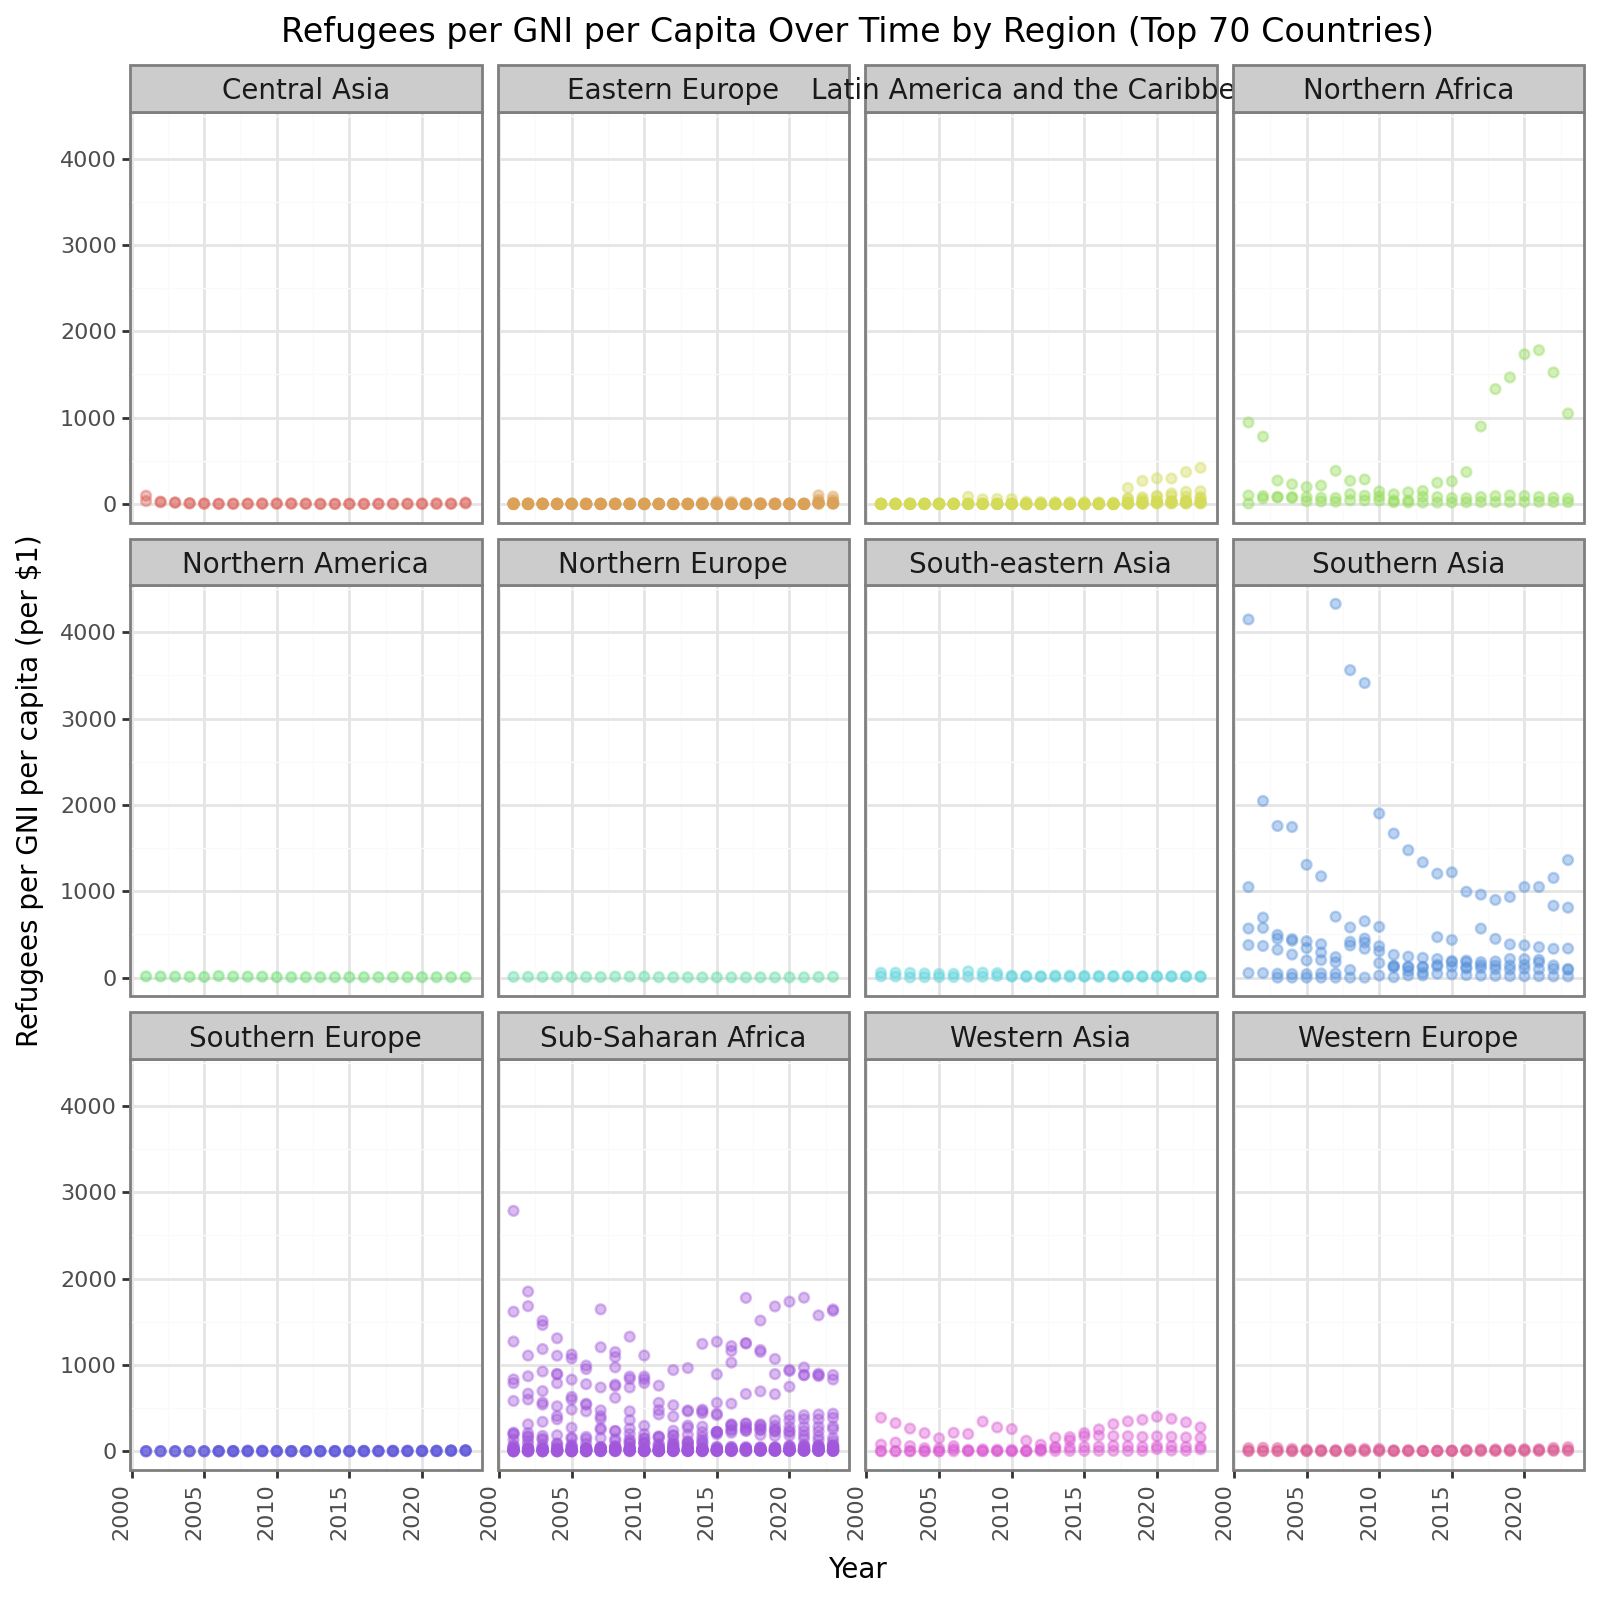

In [67]:
draw_top_countries_stat("refugees_per_gni_pc", "sub-region", 70, "Refugees per GNI per Capita Over Time by Region (Top 70 Countries)")

## Debunking Myths: Refugee Inflows and Economic Growth Dynamics
This scatter plot explores the relationship between the scale of total refugees and GDP growth across host countries. Each point represents a country-year pair, color-coded by continent, with the x-axis reflecting the refugee burden and the y-axis depicting annual GDP growth rates.

Contrary to common assumptions, the data reveals no consistent pattern of economic decline tied directly to refugee inflows. Several countries even exhibit positive growth rates despite high refugee populations, suggesting resilience and potential benefits such as labor market contributions.

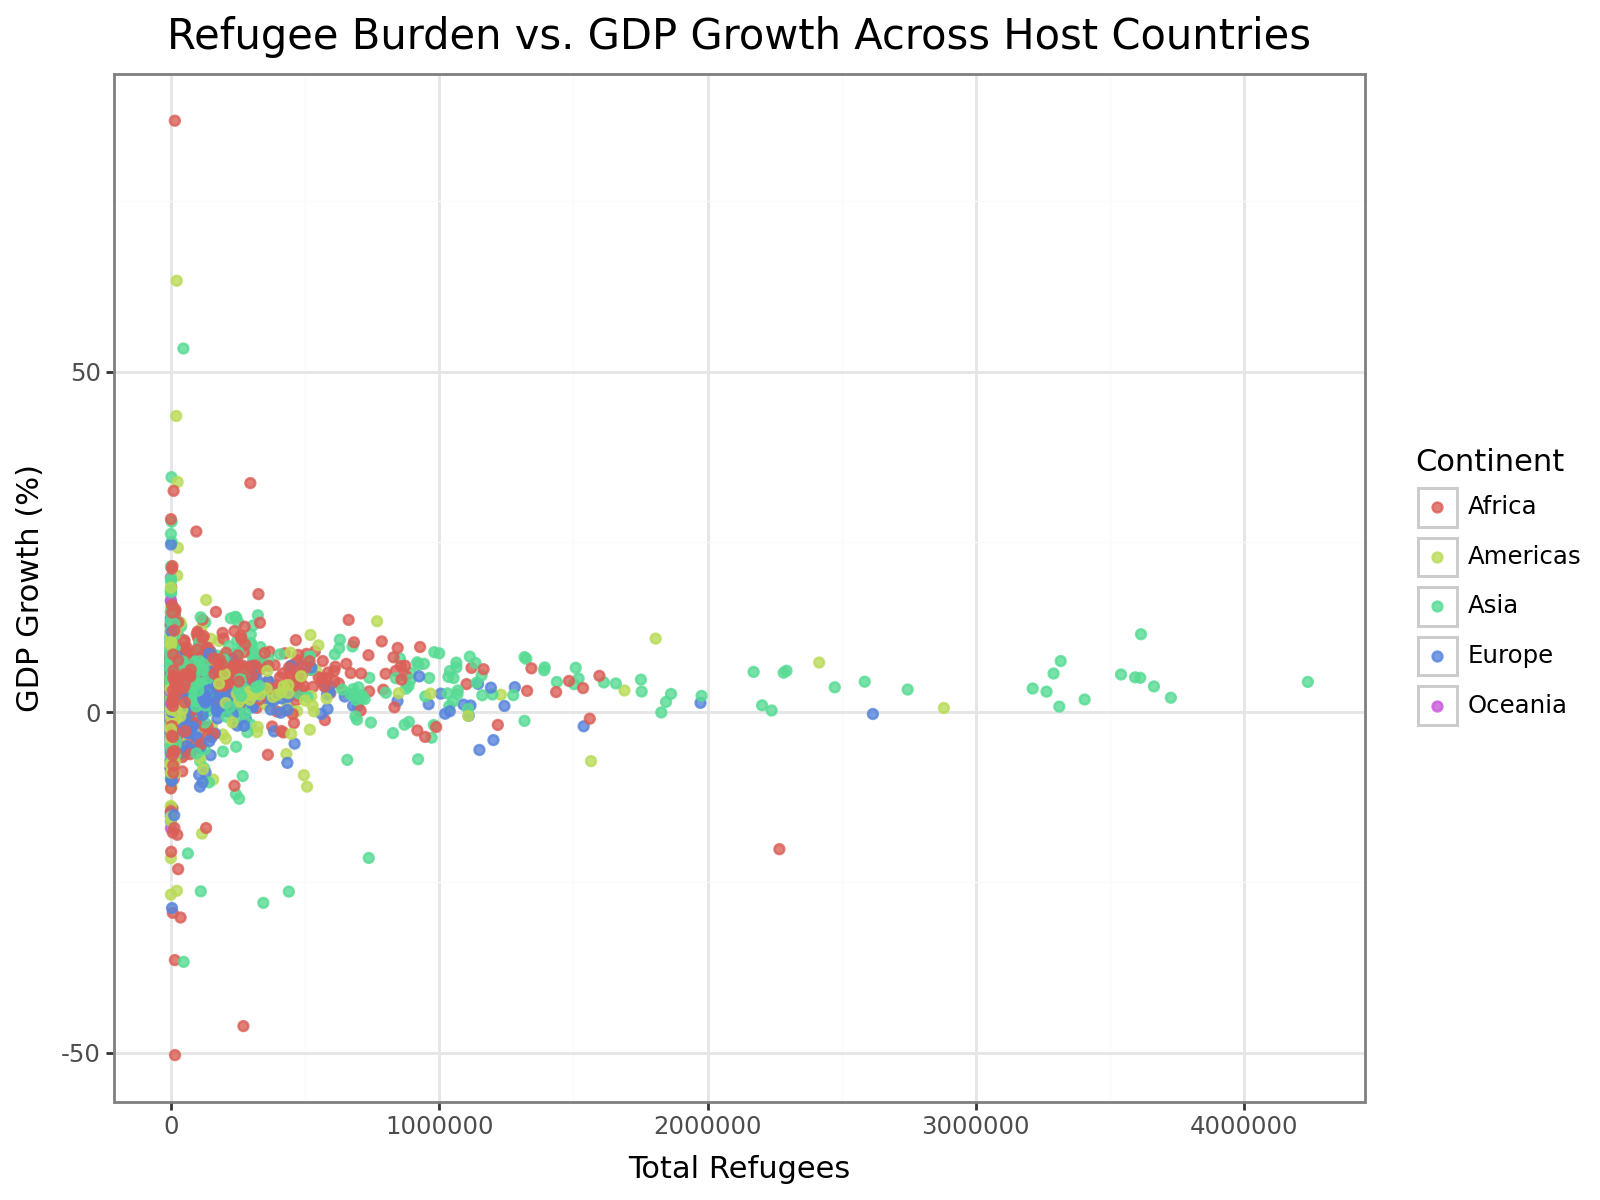

In [68]:
(
    ggplot(full_data, aes(x="total_refugees", y="gdp_growth", color="continent"))
    + geom_point(alpha=0.8)
    + labs(
        title="Refugee Burden vs. GDP Growth Across Host Countries",
        x="Total Refugees",
        y="GDP Growth (%)",
        color="Continent"
    )
    + g_theme
    + theme(
        figure_size=(8,6),
        plot_title=element_text(size=15)
    )
)

## Inflation Patterns Amidst Refugee Inflows in Major Host Nations
This line chart tracks inflation rates over time for the top refugee-hosting countries, offering insights into potential macroeconomic stress. Despite concerns that refugee inflows might drive up consumer prices, the visualization shows that inflation trends largely mirror global economic cycles, with limited direct correlation to refugee arrivals. Significant inflationary events, such as the 2008 financial crisis or 2020 pandemic shocks, appear far more influential than refugee-related factors.

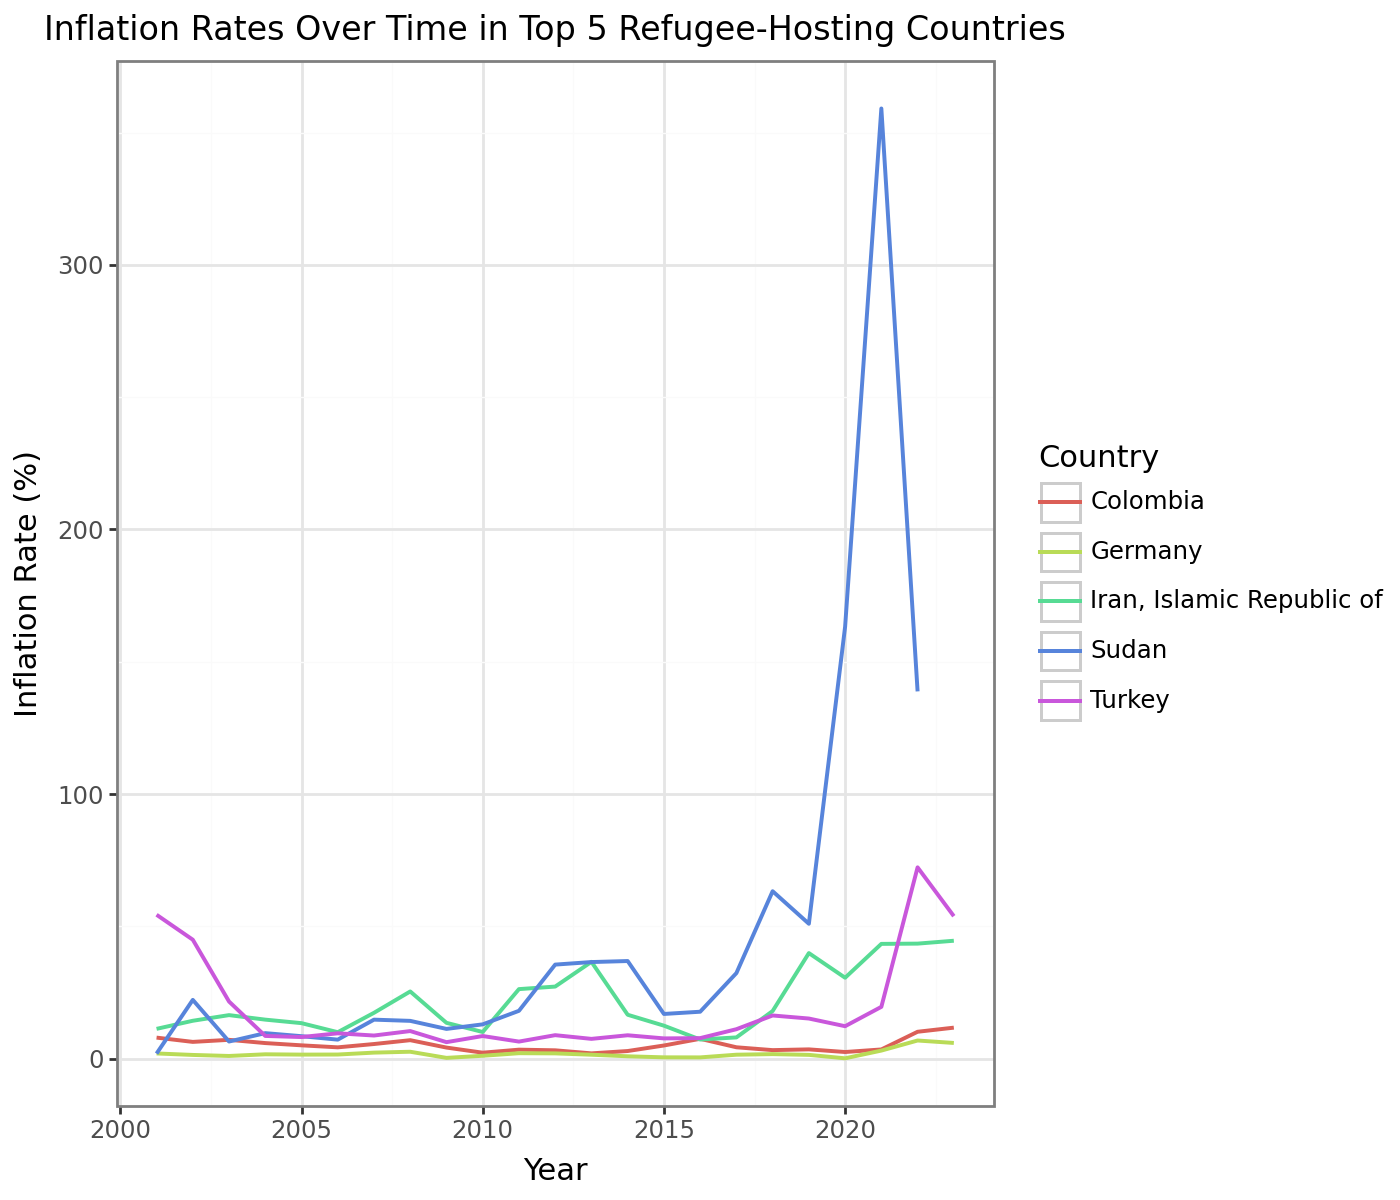

In [69]:
top_of_latest_year = (
    full_data
    .filter(pl.col("year") == latest_year)
    .sort("total_refugees", descending=True)
    .head(5)
  )
country_list = top_of_latest_year["country"].to_list()

(
  full_data
  .filter(pl.col("country").is_in(country_list))
  >>
  ggplot(aes(x="year", y="inflation", color="country"))
  + geom_line(size=0.8)
  + labs(
      title="Inflation Rates Over Time in Top 5 Refugee-Hosting Countries",
      x="Year",
      y="Inflation Rate (%)",
      color="Country"
  )
  + g_theme
  + theme(
      plot_title=element_text(size=12),
      figure_size=(7,6)
    )
)

# Conclusion

Based on the comprehensive data analysis and visualizations presented, it is evident that the impact of refugee influx on host countries' economies is multifaceted, encompassing both challenges and opportunities. The data and accompanying research suggest that while hosting refugees presents initial economic challenges, particularly for lower-income countries, the long-term effects can be neutral or even positive. Refugees can contribute to economic growth, labor market dynamism, and cultural enrichment.

## Recommendations

- **International Support:**  
  There is a need for increased international assistance to lower-income countries that host large refugee populations, ensuring they have the resources to support both refugees and their own citizens effectively.

- **Integration Policies:**  
  Implementing policies that facilitate the integration of refugees into the labor market can maximize their economic contributions and reduce potential social tensions.

- **Public Awareness:**  
  Raising awareness about the potential positive impacts of refugees can help counteract xenophobic narratives and promote more inclusive societies.

---

In conclusion, while the challenges of hosting refugees are real, they are not insurmountable. With appropriate policies and international cooperation, refugees can become valuable contributors to their host countries' economies and societies.


## 🌎 **Make a Difference** 🙌

Join us in making a significant impact on the lives around the world by supporting UNICEF's mission to provide lifesaving nutrition, water, education, and emergency relief.
Your donation can help save lives, defend rights, and fulfill the promise of a better future for Human in need.

**Together, we can create a brighter, healthier, and more equitable world for all children.**
<div style="text-align:center;">
  <a href="https://www.unicef.ie/donate/refugee-and-migrant-crisis/#1">
    <img src="https://png.pngtree.com/png-clipart/20231005/original/pngtree-red-heart-donate-button-for-financial-aid-contribute-white-financial-vector-png-image_12962245.png" alt="Donate Button" height="300">
  </a>
</div>

### **Other Ways to Donate** 🕊
You can make a donation by phone, you can reaching on 01 878 3000, our office hours are Monday to Friday 09:00 – 18:00.

**You can send your donation by post to** 🏤

Freepost,

UNICEF Ireland,

33 Lower Ormond Quay,

Dublin D01 R283.

You can help unicef reach more children affected by the conflict and natural disasters. Please donate today and help us protect children in emergencies.

In the unlikely event that the funds raised exceed UNICEF's funding requirements for this appeal, your donation will be directed to where the need is greatest.

<div style="text-align: center;">
  <a href="https://www.linkedin.com/company/unicef-ireland/" target="_blank">
    <img src="https://www.pngplay.com/wp-content/uploads/9/Linkedin-Transparent-PNG.png" alt="LinkedIn" height="40">
  </a>
  <a href="https://x.com/unicefireland?lang=en" target="_blank">
    <img src="https://images.icon-icons.com/4029/PNG/512/twitter_x_new_logo_x_rounded_icon_256078.png" alt="Twitter" height="40">
  </a>
  <a href="https://www.facebook.com/UNICEFIreland/" target="_blank">
    <img src="https://upload.wikimedia.org/wikipedia/commons/c/cd/Facebook_logo_%28square%29.png" alt="Facebook" height="40">
  </a>
</div>
